# Sentiment Analysis of FOMC Statements

Analyse statement by Loughran and McDonald dictionary

In [1]:
%config InlineBackend.figure_format='retina'
import logging
from ekorpkit import eKonf

logging.basicConfig(level=logging.INFO)
print("version:", eKonf.__version__)
print("is notebook?", eKonf.is_notebook())
print("is colab?", eKonf.is_colab())
print("evironment varialbles:")
eKonf.print(eKonf.env().dict())

INFO:ekorpkit.base:IPython version: (6, 9, 0), client: jupyter_client
INFO:ekorpkit.base:Google Colab not detected.


version: 0.1.33+23.gbb9860e.dirty
is notebook? True
is colab? False
evironment varialbles:
{'EKORPKIT_CONFIG_DIR': '/workspace/projects/ekorpkit-book/config',
 'EKORPKIT_DATA_DIR': None,
 'EKORPKIT_PROJECT': 'ekorpkit-book',
 'EKORPKIT_WORKSPACE_ROOT': '/workspace',
 'NUM_WORKERS': 230}


In [41]:
start_year = 2000
data_dir = "../data/fomc"
eKonf.env().FRED_API_KEY

pydantic.types.SecretStr

## Load FOMC Corpus

In [42]:
fomc_sents = eKonf.load_data("fomc_sents.parquet", data_dir)
fomc_sents.tail()

INFO:ekorpkit.io.file:Processing [1] files from ['fomc_sents.parquet']
INFO:ekorpkit.io.file:Loading 1 dataframes from ['../data/fomc/fomc_sents.parquet']
INFO:ekorpkit.io.file:Loading data from ../data/fomc/fomc_sents.parquet


,id,text,timestamp,content_type,date,speaker,title,decision,rate,next_meeting,next_decision,next_rate,text_num_words,section_id,sent_id
653463,2854,It will not have the word “somewhat” on line 3.,2014-12-17,fomc_meeting_script,2014-12-17,MR. LUECKE,FOMC Meeting Transcript,0.0,0.25,2015-01-28,0.0,0.25,10,287,2
653464,2854,Chair Yellen Yes Vice Chairman Dudley ...,2014-12-17,fomc_meeting_script,2014-12-17,MR. LUECKE,FOMC Meeting Transcript,0.0,0.25,2015-01-28,0.0,0.25,31,287,4
653465,2854,And let me confirm that the next meeting will ...,2014-12-17,fomc_meeting_script,2014-12-17,CHAIR YELLEN,FOMC Meeting Transcript,0.0,0.25,2015-01-28,0.0,0.25,19,288,3
653466,2854,I believe box lunches are now available for pe...,2014-12-17,fomc_meeting_script,2014-12-17,CHAIR YELLEN,FOMC Meeting Transcript,0.0,0.25,2015-01-28,0.0,0.25,33,288,4
653467,2854,"I will do my best, and I will consider at the ...",2014-12-17,fomc_meeting_script,2014-12-17,CHAIR YELLEN,FOMC Meeting Transcript,0.0,0.25,2015-01-28,0.0,0.25,18,288,5


## Predict sentiments with the LM sentiment analyser

In [43]:
model_cfg = eKonf.compose('model/sentiment=lm')
# model_cfg.verbose = 10
model_cfg.num_workers = 10
lmsa = eKonf.instantiate(model_cfg)

INFO:ekorpkit.preprocessors.tokenizer:instantiating ekorpkit.preprocessors.stopwords.Stopwords...
INFO:ekorpkit.base:Calling load_candidates
INFO:ekorpkit.io.file:Processing [1] files from ['/workspace/projects/ekorpkit/ekorpkit/resources/lexicons/LM.parquet']
INFO:ekorpkit.io.file:Loading 1 dataframes from ['/workspace/projects/ekorpkit/ekorpkit/resources/lexicons/LM.parquet']
INFO:ekorpkit.io.file:Loading data from /workspace/projects/ekorpkit/ekorpkit/resources/lexicons/LM.parquet
INFO:ekorpkit.models.ngram.ngram:loaded 58142 candidates


In [44]:
article = fomc_sents.text[10]
lmsa.predict_sentence(article)

{'num_tokens': 156,
 'polarity': -0.9999990000010001,
 'polarity_label': 'negative',
 'uncertainty': 1e-06}

In [47]:
model_cfg = eKonf.compose('model/sentiment=lm')

cfg = eKonf.compose('pipeline/predict')
cfg.name = 'fomc_sentiments'
cfg.model = model_cfg
cfg.output_dir = "../data/predict"
cfg.output_file = f'{cfg.name}-lm.parquet'
cfg.num_workers = 100
cfg.verbose = True
fomc_data = eKonf.pipe(fomc_sents, cfg)
fomc_data.head()

INFO:ekorpkit.base:Applying pipe: functools.partial(<function predict at 0x7fdbcc08ec10>)
INFO:ekorpkit.base:instantiating ekorpkit.models.sentiment.base.SentimentAnalyser...
INFO:ekorpkit.preprocessors.tokenizer:instantiating ekorpkit.preprocessors.stopwords.Stopwords...
INFO:ekorpkit.base:Calling load_candidates
INFO:ekorpkit.io.file:Processing [1] files from ['/workspace/projects/ekorpkit/ekorpkit/resources/lexicons/LM.parquet']
INFO:ekorpkit.io.file:Loading 1 dataframes from ['/workspace/projects/ekorpkit/ekorpkit/resources/lexicons/LM.parquet']
INFO:ekorpkit.io.file:Loading data from /workspace/projects/ekorpkit/ekorpkit/resources/lexicons/LM.parquet
INFO:ekorpkit.models.ngram.ngram:loaded 58142 candidates
INFO:ekorpkit.models.sentiment.base:Predicting sentiments of the column [text] using predict_sentence
INFO:ekorpkit.base:Using batcher with minibatch size: 1000
INFO:ekorpkit.utils.batch.batcher: backend: joblib  minibatch_size: 1000  procs: 100  input_split: False  merge_output

,id,text,timestamp,content_type,date,speaker,title,decision,rate,next_meeting,next_decision,next_rate,text_num_words,section_id,sent_id,num_tokens,polarity,polarity_label,uncertainty
0,0,The Secretary reported that advices of the ele...,1993-02-03,fomc_minutes,1993-02-03,Alan Greenspan,FOMC Meeting Minutes,0.0,3.0,1993-02-18,0.0,3.0,47,29,0,52,0.000000,neutral,0.000001
1,0,"By unanimous vote, the Committee elected the f...",1993-02-03,fomc_minutes,1993-02-03,Alan Greenspan,FOMC Meeting Minutes,0.0,3.0,1993-02-18,0.0,3.0,73,35,0,78,-1.000000,negative,0.000001
2,0,"By unanimous vote, William J. McDonough, Marga...",1993-02-03,fomc_minutes,1993-02-03,Alan Greenspan,FOMC Meeting Minutes,0.0,3.0,1993-02-18,0.0,3.0,74,37,0,83,1.000000,positive,0.000001
3,0,"On January 15, 1993, the continuing rules, reg...",1993-02-03,fomc_minutes,1993-02-03,Alan Greenspan,FOMC Meeting Minutes,0.0,3.0,1993-02-18,0.0,3.0,59,39,0,68,-0.333333,negative,0.014707
4,0,Members were asked to indicate if they wished ...,1993-02-03,fomc_minutes,1993-02-03,Alan Greenspan,FOMC Meeting Minutes,0.0,3.0,1993-02-18,0.0,3.0,25,39,1,26,-0.999999,negative,0.000001


In [48]:
cfg = eKonf.compose('pipeline/predict')
cfg.name = 'fomc_sentiments'
cfg.output_dir = "../data/predict"
cfg.output_file = f'{cfg.name}-lm.parquet'

fomc_data = eKonf.load_data(cfg.output_file, cfg.output_dir)
fomc_data.head()

INFO:ekorpkit.io.file:Processing [1] files from ['fomc_sentiments-lm.parquet']
INFO:ekorpkit.io.file:Loading 1 dataframes from ['../data/predict/fomc_sentiments-lm.parquet']
INFO:ekorpkit.io.file:Loading data from ../data/predict/fomc_sentiments-lm.parquet


,id,text,timestamp,content_type,date,speaker,title,decision,rate,next_meeting,next_decision,next_rate,text_num_words,section_id,sent_id,num_tokens,polarity,polarity_label,uncertainty
0,0,The Secretary reported that advices of the ele...,1993-02-03,fomc_minutes,1993-02-03,Alan Greenspan,FOMC Meeting Minutes,0.0,3.0,1993-02-18,0.0,3.0,47,29,0,52,0.000000,neutral,0.000001
1,0,"By unanimous vote, the Committee elected the f...",1993-02-03,fomc_minutes,1993-02-03,Alan Greenspan,FOMC Meeting Minutes,0.0,3.0,1993-02-18,0.0,3.0,73,35,0,78,-1.000000,negative,0.000001
2,0,"By unanimous vote, William J. McDonough, Marga...",1993-02-03,fomc_minutes,1993-02-03,Alan Greenspan,FOMC Meeting Minutes,0.0,3.0,1993-02-18,0.0,3.0,74,37,0,83,1.000000,positive,0.000001
3,0,"On January 15, 1993, the continuing rules, reg...",1993-02-03,fomc_minutes,1993-02-03,Alan Greenspan,FOMC Meeting Minutes,0.0,3.0,1993-02-18,0.0,3.0,59,39,0,68,-0.333333,negative,0.014707
4,0,Members were asked to indicate if they wished ...,1993-02-03,fomc_minutes,1993-02-03,Alan Greenspan,FOMC Meeting Minutes,0.0,3.0,1993-02-18,0.0,3.0,25,39,1,26,-0.999999,negative,0.000001


In [29]:
fomc_data.set_index("timestamp", inplace=True)
fomc_data

,id,text,split,content_type,date,speaker,title,num_examples,polarity_mean,polarity_diffusion,positive,negative,num_tokens_sum,num_tokens_mean,num_tokens_median,polarity_mean_label,polarity_diffusion_label,uncertainty_mean,uncertainty_median
timestamp,,,,,,,,,,,,,,,,,,,
1996-06-26,2151,It is a pleasure to appear before this Subcomm...,train,fomc_testimony,1996-06-26,"Governor Edward W. Kelley, Jr.",Supervision of bank sales practices,25,-0.084000,-0.080000,7.0,9.0,2498.0,99.920000,91.0,neutral,neutral,0.010197,0.007693
1996-07-17,2152,I am pleased to appear before the Committee on...,train,fomc_testimony,1996-07-17,"Herbert A. Biern, Deputy Associate Director, D...","""Prime bank"" schemes",19,-0.512030,-0.631579,0.0,12.0,1439.0,75.736842,48.0,negative,negative,0.011933,0.000001
1996-07-18,2153,Testimony of Chairman Alan Greenspan The Feder...,train,fomc_testimony,1996-07-18,Chairman Alan Greenspan,The Federal Reserve's semiannual monetary report,30,0.079947,0.133333,14.0,10.0,3732.0,124.400000,134.0,neutral,neutral,0.010476,0.007197
1996-07-24,2154,I am pleased to appear before this Subcommitte...,train,fomc_testimony,1996-07-24,Governor Janet L. Yellen,Trends in consumer lending,28,-0.278410,-0.535714,5.0,20.0,3194.0,114.071429,114.5,negative,negative,0.011687,0.011434
1996-07-26,2155,I appreciate this opportunity to appear before...,train,fomc_testimony,1996-07-26,Chairman Alan Greenspan,Recent reports on Federal Reserve operations,36,0.043541,0.083333,17.0,14.0,4082.0,113.388889,103.5,neutral,neutral,0.010455,0.009263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-19,2597,"The Federal Reserve, the central bank of the U...",train,fomc_testimony,2021-05-19,Vice Chair for Supervision Randal K. Quarles,Supervision and Regulation,49,-0.083317,-0.122449,8.0,14.0,3155.0,64.387755,59.0,neutral,neutral,0.005352,0.000001
2021-06-22,2598,"The Federal Reserve, the central bank of the U...",train,fomc_testimony,2021-06-22,Chair Jerome H. Powell,The Federal Reserve's Response to the Coronavi...,42,0.055952,0.047619,10.0,8.0,1902.0,45.285714,26.5,neutral,neutral,0.002511,0.000001
2021-07-14,2599,"The Federal Reserve, the central bank of the U...",train,fomc_testimony,2021-07-14,Chair Jerome H. Powell,Semiannual Monetary Policy Report to the Congress,28,0.265646,0.357143,11.0,1.0,1318.0,47.071429,27.0,positive,positive,0.001904,0.000001


## Plot the sentiment scores

INFO:ekorpkit.visualize.plot:Plotting lineplot with {'linewidth': 2, 'palette': None, 'hue': None, 'size': None, 'style': None, 'hue_order': None, 'hue_norm': None, 'sizes': None, 'size_order': None, 'size_norm': None, 'dashes': True, 'markers': None, 'style_order': None, 'units': None, 'estimator': 'mean', 'ci': 95, 'n_boot': 1000, 'seed': None, 'sort': True, 'err_style': 'band', 'err_kws': None, 'legend': 'auto', 'drawstyle': None}
INFO:ekorpkit.visualize.base:Saved figure to /workspace/projects/ekorpkit-book/outputs/figs/LinePlot.png


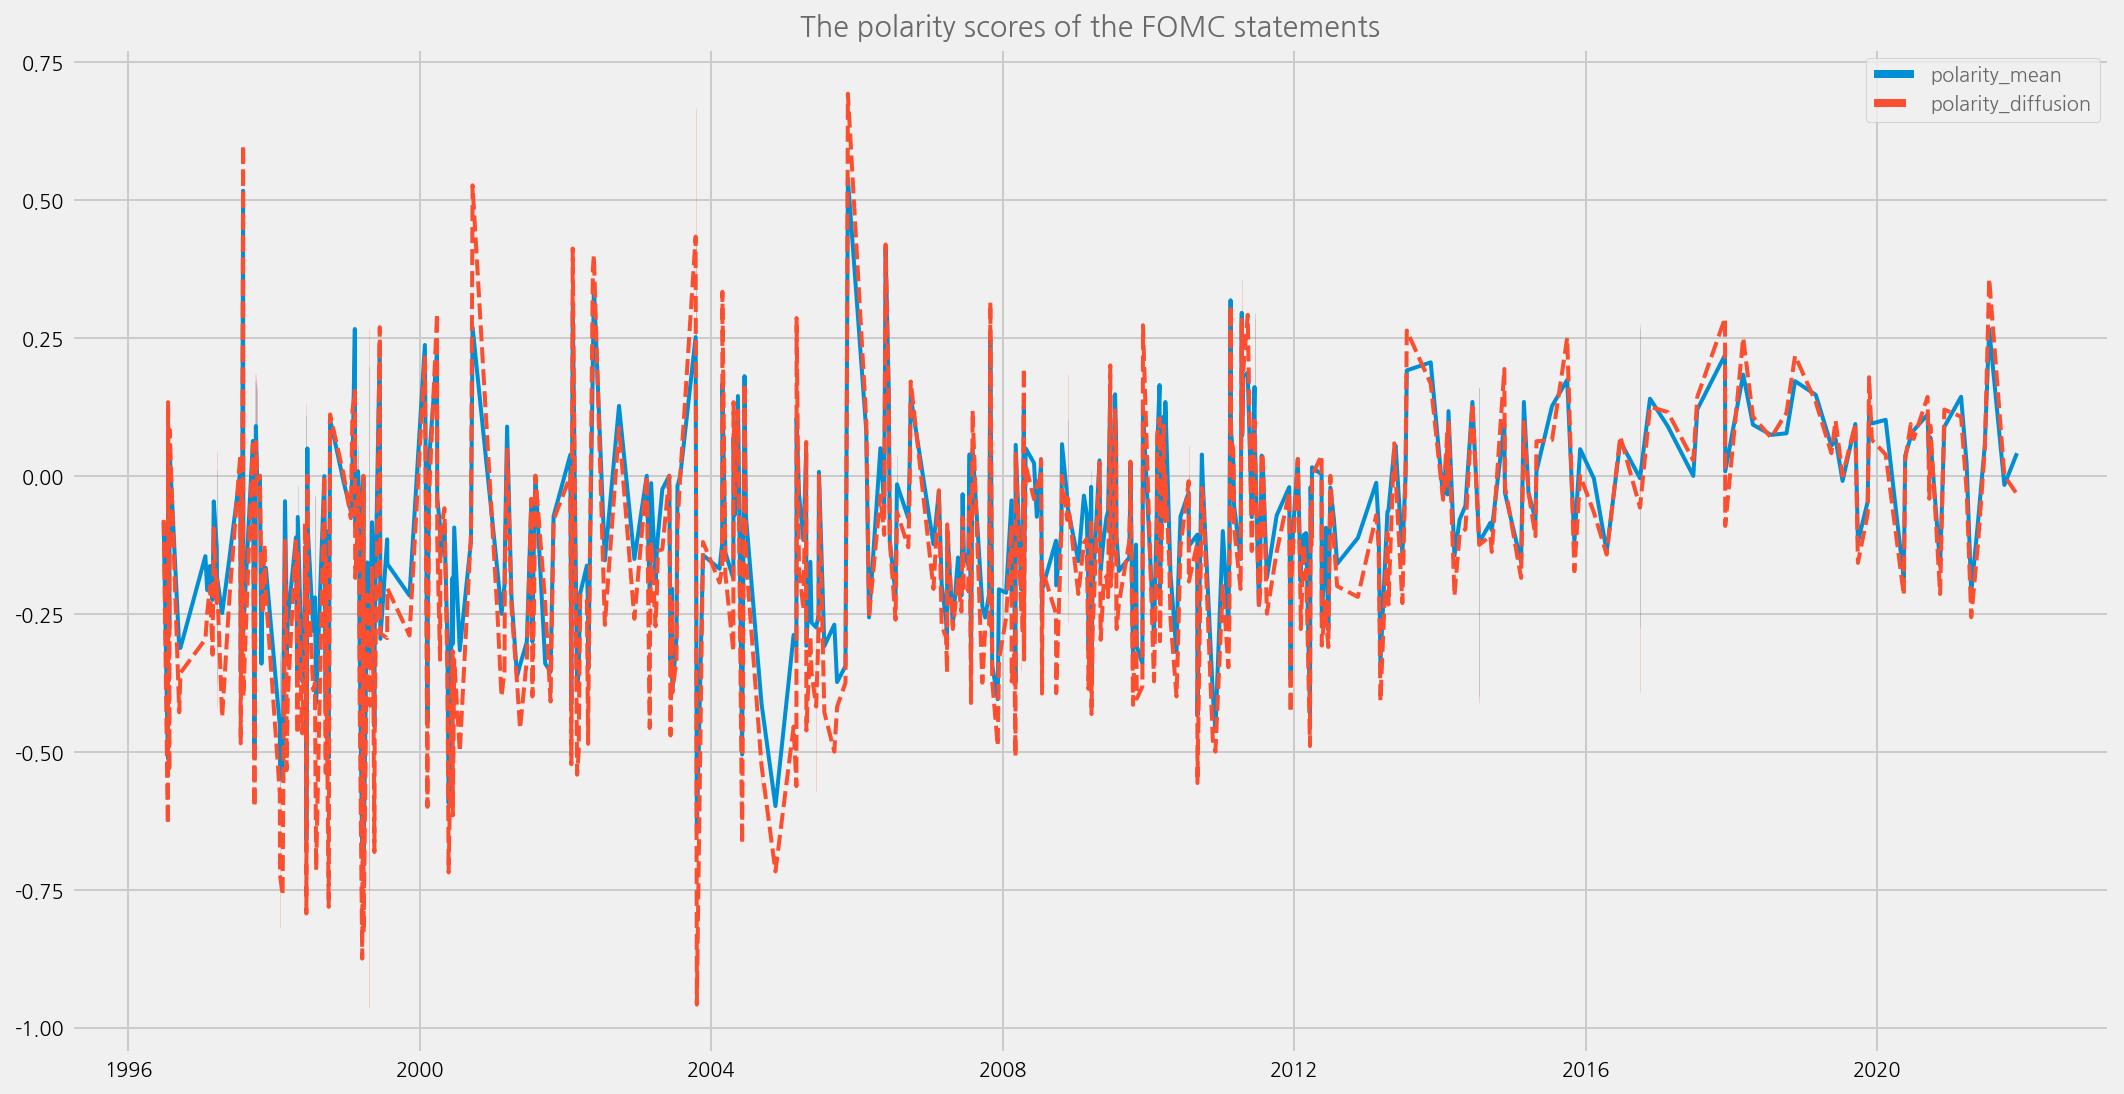

In [30]:
cfg = eKonf.compose('visualize/plot=lineplot')
# cfg.plot.x = 'timestamp'
cfg.plot.y = ['polarity_mean', 'polarity_diffusion']
cfg.figure.figsize = '(15, 8)'
cfg.ax.title = 'The polarity scores of the FOMC statements'
eKonf.instantiate(cfg, data=fomc_data)

INFO:ekorpkit.visualize.plot:Plotting lineplot with {'linewidth': 2, 'color': 'red', 'x': 'timestamp', 'y': 'num_tokens_sum', 'palette': None, 'hue': None, 'size': None, 'style': None, 'hue_order': None, 'hue_norm': None, 'sizes': None, 'size_order': None, 'size_norm': None, 'dashes': True, 'markers': None, 'style_order': None, 'units': None, 'estimator': 'mean', 'ci': 95, 'n_boot': 1000, 'seed': None, 'sort': True, 'err_style': 'band', 'err_kws': None, 'legend': 'auto', 'drawstyle': None}


InstantiationException: Error in call to target 'ekorpkit.visualize.plot.plot':
ValueError('cannot reindex from a duplicate axis')
full_key: visualize.plot

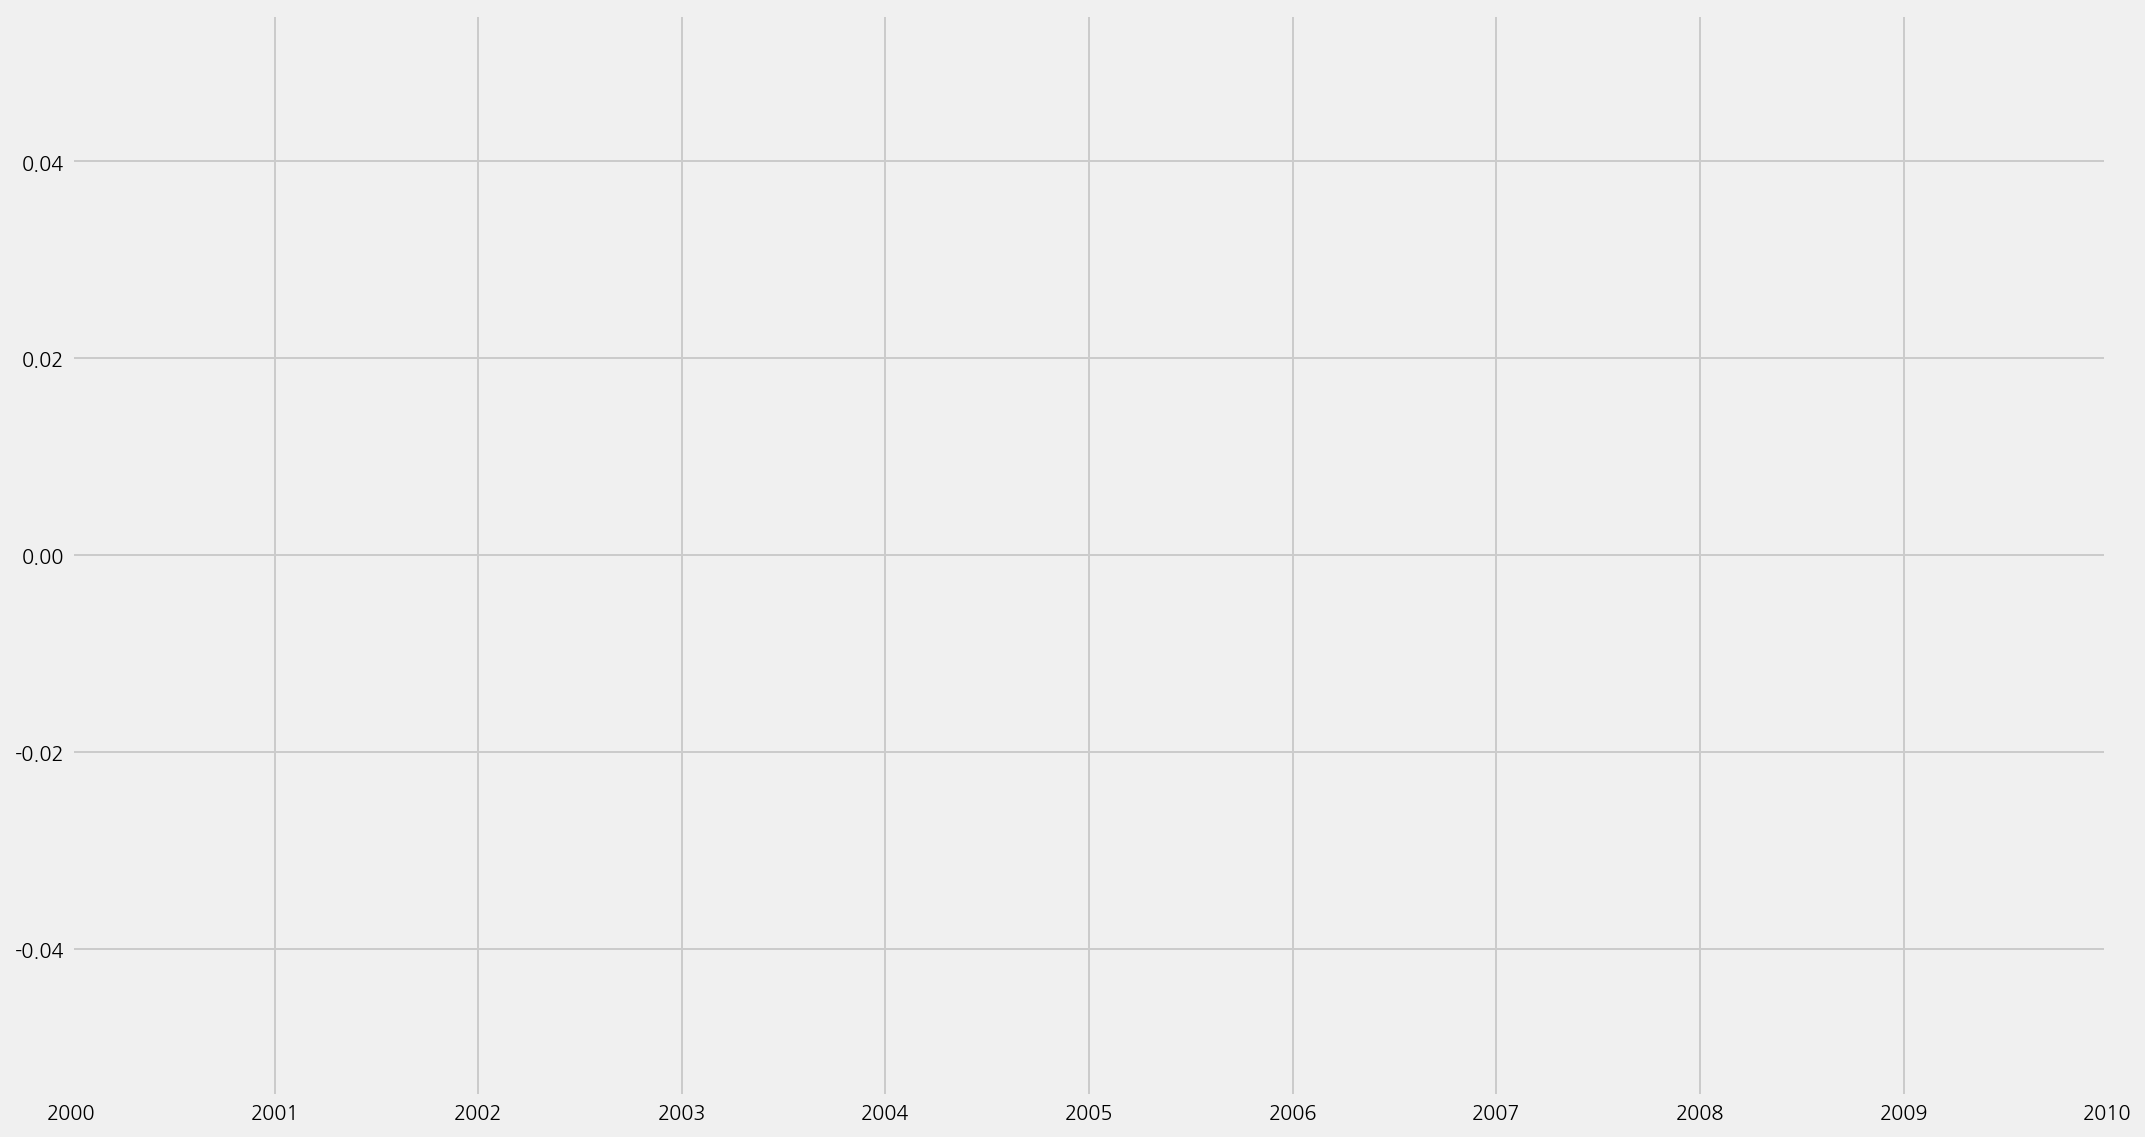

In [32]:
cfg = eKonf.compose('visualize/plot=lineplot')
cfg.figure.figsize = (15, 8)
cfg.plots.append(cfg.plot.copy())
cfg.plots[0].y = "num_tokens_sum"
cfg.plots[0].rcParams = dict(linewidth=2.5, color="red")
cfg.plots[1].y = "num_examples"
cfg.plots[1].rcParams = dict(linewidth=1.5, color="green")
cfg.plots[1].secondary_y = True
cfg.ax.legend = dict(
    labels=[
        "The number of tokens in the FOMC statements (LHS)",
    ],
    loc=2,
)
ax2 = cfg.ax.copy()
ax2.grid = False
ax2.secondary_y = True
ax2.legend = dict(
    labels=["The number of sentences in the FOMC statements (RHS)"],
    loc=1,
)
cfg.axes.append(ax2)

eKonf.instantiate(cfg, data=fomc_data)

INFO:ekorpkit.visualize.plot:Plotting lineplot with {'linewidth': 2.5, 'palette': ['b', 'r'], 'hue': None, 'size': None, 'style': None, 'hue_order': None, 'hue_norm': None, 'sizes': None, 'size_order': None, 'size_norm': None, 'dashes': True, 'markers': None, 'style_order': None, 'units': None, 'estimator': 'mean', 'ci': 95, 'n_boot': 1000, 'seed': None, 'sort': True, 'err_style': 'band', 'err_kws': None, 'legend': 'auto', 'drawstyle': None}
INFO:ekorpkit.visualize.base:Saved figure to /workspace/projects/ekorpkit-book/outputs/figs/LinePlot.png


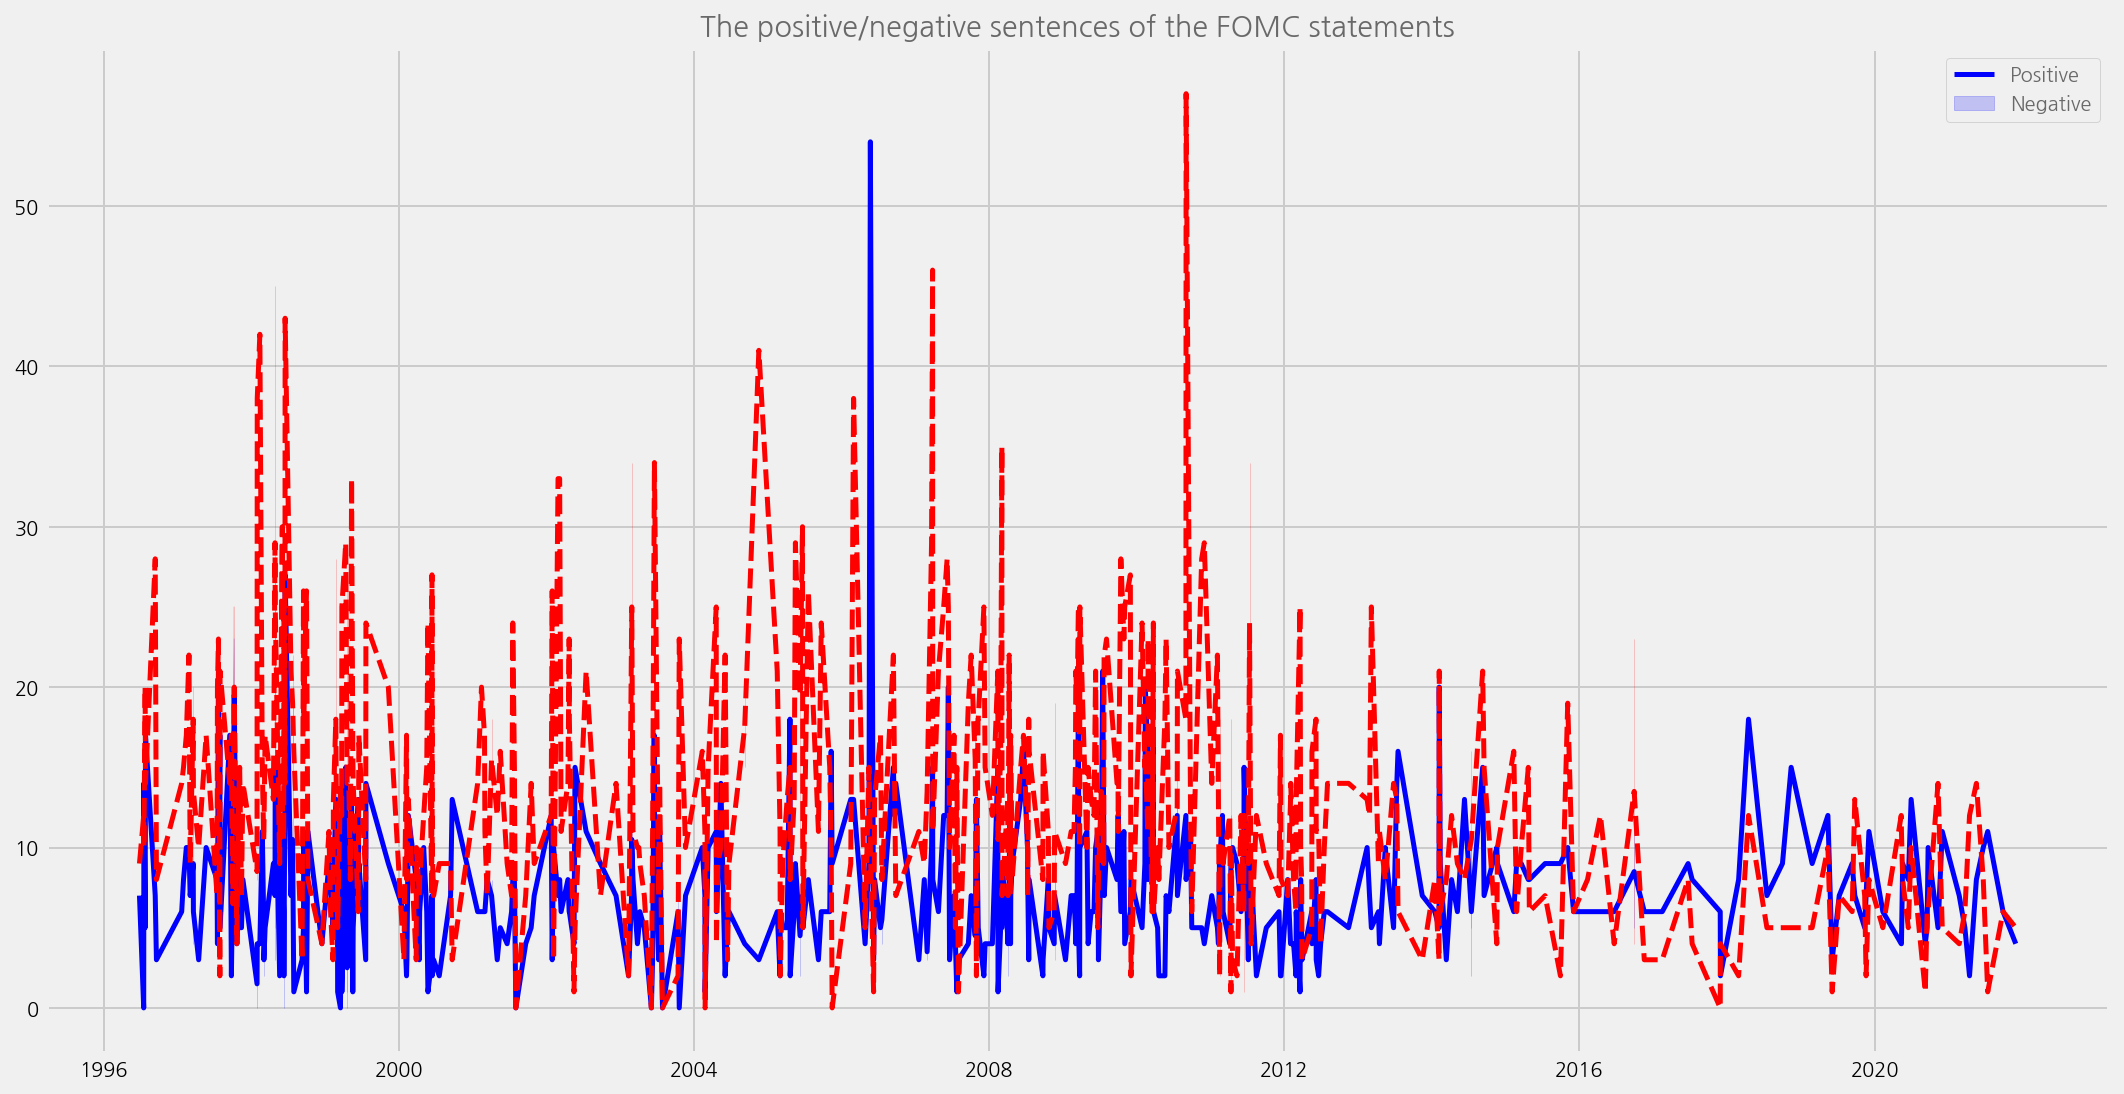

In [33]:
cfg = eKonf.compose("visualize/plot=lineplot")
cfg.plot.y = ["positive", "negative"]
cfg.plot.palette = ["b", "r"]
cfg.plot.linewidth = 2.5
cfg.figure.figsize = (15, 8)
cfg.ax.title = "The positive/negative sentences of the FOMC statements"
cfg.ax.legend.labels = ["Positive", "Negative"]
eKonf.instantiate(cfg, data=fomc_data)

INFO:ekorpkit.visualize.base:Saved figure to /workspace/projects/ekorpkit-book/outputs/figs/StackPlot.png


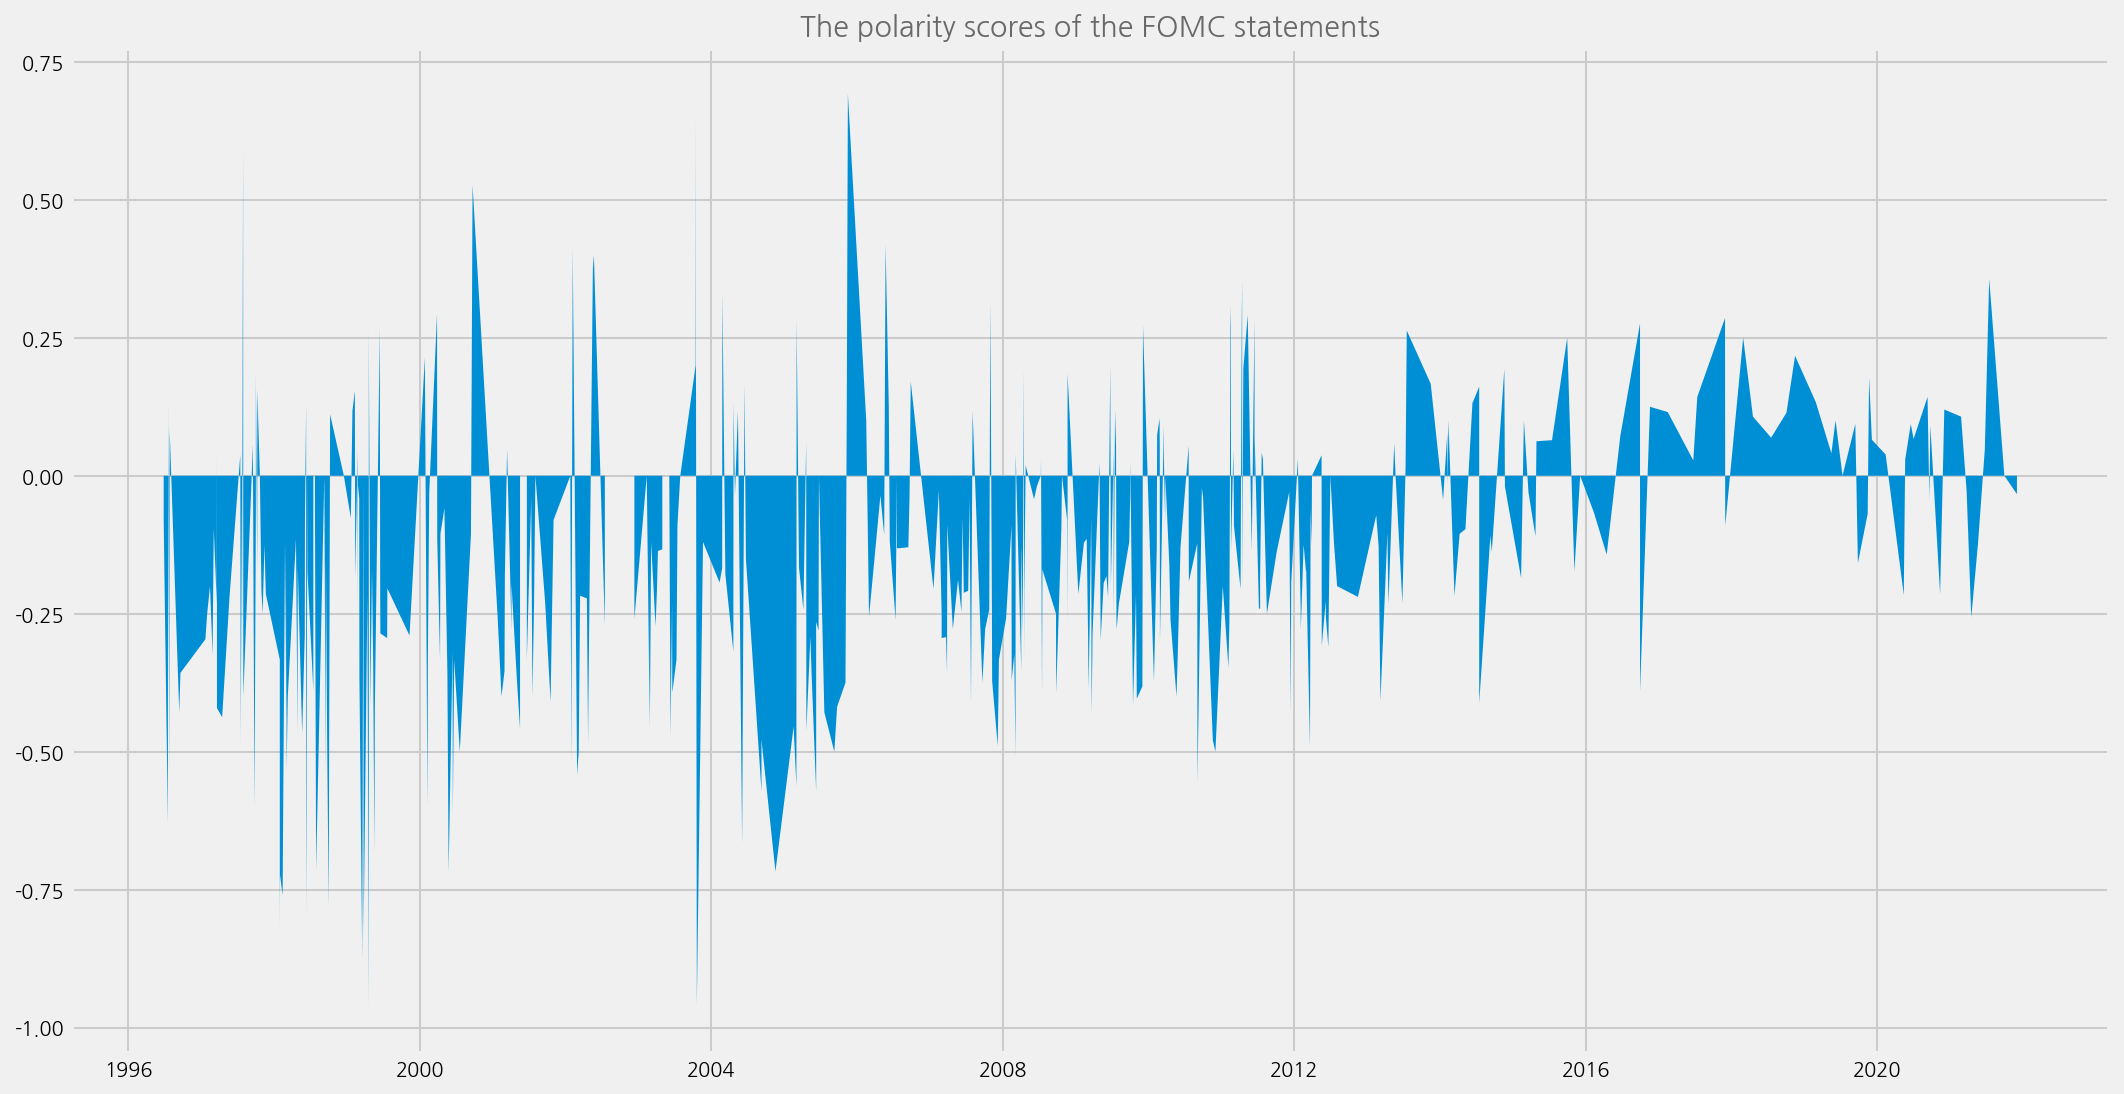

In [34]:
cfg = eKonf.compose('visualize/plot=stackplot')
cfg.plot.y = ['polarity_diffusion']
cfg.figure.figsize = (15, 8)
cfg.ax.title = 'The polarity scores of the FOMC statements'
cfg.ax.xtickmajorformatterfunc = "mdates.DateFormatter('%Y')"
eKonf.instantiate(cfg, data=fomc_data)


### Merge with fed rate data

INFO:ekorpkit.base:Applying pipe: functools.partial(<function eval_columns at 0x7fdbcc08e310>)
INFO:ekorpkit.base:Applying pipe: functools.partial(<function eval_columns at 0x7fdbcc08e310>)
INFO:ekorpkit.io.file:Saving dataframe to /workspace/.tmp/fred/DFEDTAR.parquet
INFO:ekorpkit.visualize.plot:Plotting lineplot with {'x': 'date', 'y': 'DFEDTAR', 'linewidth': 2, 'palette': None, 'hue': None, 'size': None, 'style': None, 'hue_order': None, 'hue_norm': None, 'sizes': None, 'size_order': None, 'size_norm': None, 'dashes': True, 'markers': None, 'style_order': None, 'units': None, 'estimator': 'mean', 'ci': 95, 'n_boot': 1000, 'seed': None, 'sort': True, 'err_style': 'band', 'err_kws': None, 'legend': 'auto', 'drawstyle': None}
INFO:ekorpkit.visualize.base:Saved figure to /workspace/projects/ekorpkit-book/outputs/figs/LinePlot.png


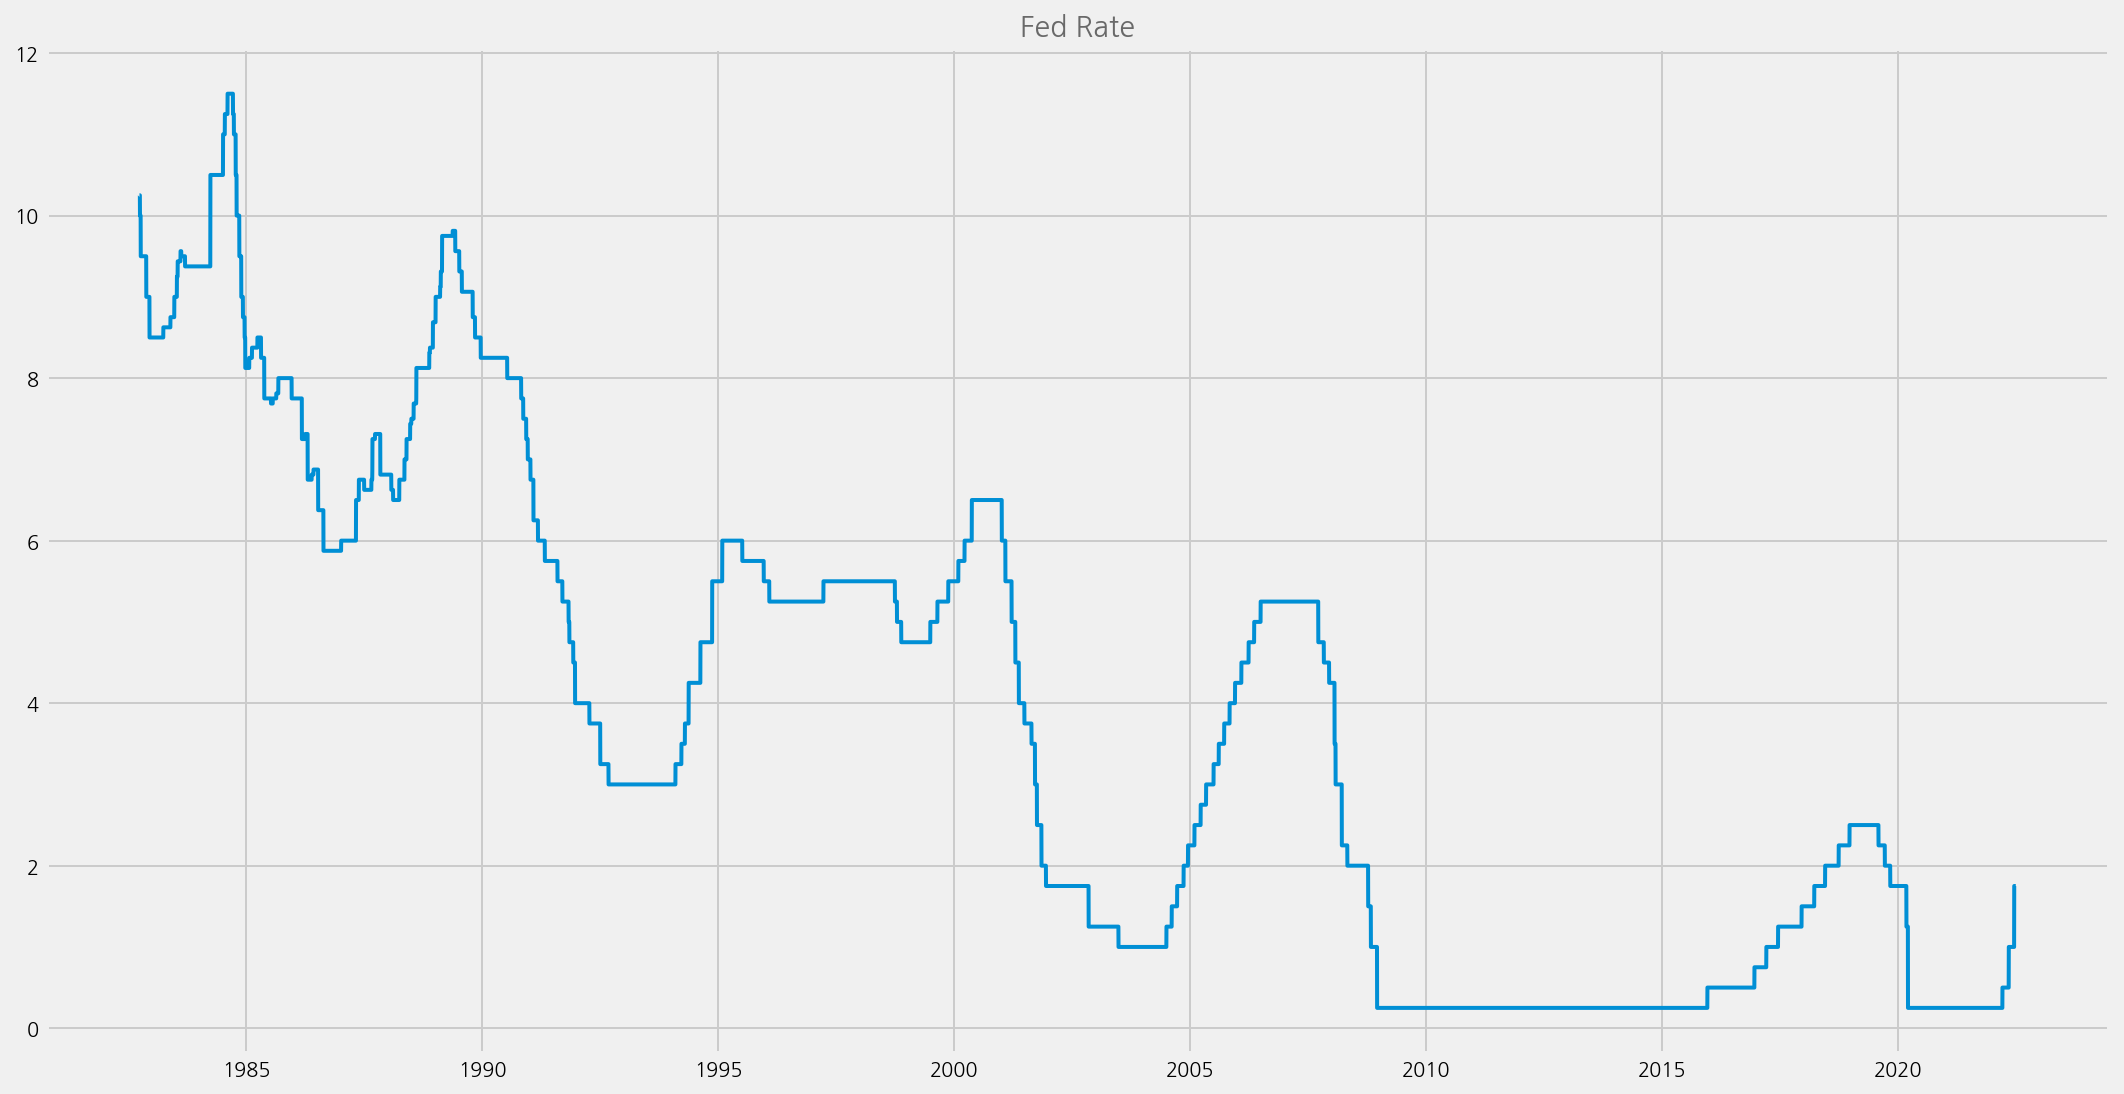

In [35]:
cfg = eKonf.compose("io/fetcher=quandl")
cfg.series_name = "DFEDTAR"
cfg.series_id = ["DFEDTAR", "DFEDTARU"]
cfg.force_download = True
quandl = eKonf.instantiate(cfg)

fedrates = quandl.data.copy()

cfg = eKonf.compose('visualize/plot=lineplot')
cfg.plot.x = 'date'
cfg.plot.y = 'DFEDTAR'
cfg.figure.figsize = (15, 8)
cfg.ax.title = 'Fed Rate'
eKonf.instantiate(cfg, data=fedrates)

In [36]:
fomc_data = fomc_data.merge(fedrates, left_index=True, right_index=True)
fomc_data.index.name = 'timestamp'
fomc_data.head()

,id,text,split,content_type,date,speaker,title,num_examples,polarity_mean,polarity_diffusion,...,negative,num_tokens_sum,num_tokens_mean,num_tokens_median,polarity_mean_label,polarity_diffusion_label,uncertainty_mean,uncertainty_median,DFEDTAR,series_id
timestamp,,,,,,,,,,,,,,,,,,,,,
1996-06-26,2151,It is a pleasure to appear before this Subcomm...,train,fomc_testimony,1996-06-26,"Governor Edward W. Kelley, Jr.",Supervision of bank sales practices,25,-0.084000,-0.080000,...,9.0,2498.0,99.920000,91.0,neutral,neutral,0.010197,0.007693,5.25,DFEDTAR
1996-07-17,2152,I am pleased to appear before the Committee on...,train,fomc_testimony,1996-07-17,"Herbert A. Biern, Deputy Associate Director, D...","""Prime bank"" schemes",19,-0.512030,-0.631579,...,12.0,1439.0,75.736842,48.0,negative,negative,0.011933,0.000001,5.25,DFEDTAR
1996-07-18,2153,Testimony of Chairman Alan Greenspan The Feder...,train,fomc_testimony,1996-07-18,Chairman Alan Greenspan,The Federal Reserve's semiannual monetary report,30,0.079947,0.133333,...,10.0,3732.0,124.400000,134.0,neutral,neutral,0.010476,0.007197,5.25,DFEDTAR
1996-07-24,2154,I am pleased to appear before this Subcommitte...,train,fomc_testimony,1996-07-24,Governor Janet L. Yellen,Trends in consumer lending,28,-0.278410,-0.535714,...,20.0,3194.0,114.071429,114.5,negative,negative,0.011687,0.011434,5.25,DFEDTAR
1996-07-26,2155,I appreciate this opportunity to appear before...,train,fomc_testimony,1996-07-26,Chairman Alan Greenspan,Recent reports on Federal Reserve operations,36,0.043541,0.083333,...,14.0,4082.0,113.388889,103.5,neutral,neutral,0.010455,0.009263,5.25,DFEDTAR


### Plot the results and compare to the economical uncertainty / systemic risk periods

In [37]:
cfg = eKonf.compose("io/fetcher/fomc")
cfg.output_dir = "../data/fomc"
fomc = eKonf.instantiate(cfg)

INFO:ekorpkit.io.fetch.fomc.base:Initializing fomc_base


In [38]:
recessions = fomc.recessions.to_dict(orient="records")

span_args = eKonf.compose("visualize/plot/ax/axvspan")
annot_args = eKonf.compose("visualize/plot/ax/annotation")
span_args.color = "crimson"
span_args.alpha = 0.4

spans = []
annotations = []
for span in recessions:
    annotation = span["name"]
    start = span["from_date"]
    end = span["to_date"]
    span = span_args.copy()
    span.xmin, span.xmax = eKonf.to_dateparm(start), eKonf.to_dateparm(end)

    x = start + (end - start) / 2
    y = -0.75
    annot = annot_args.copy()
    annot.text, annot.x, annot.y = annotation, eKonf.to_dateparm(x), y
    spans.append(span)
    annotations.append(annot)


INFO:ekorpkit.visualize.plot:Plotting lineplot with {'x': 'timestamp', 'y': 'polarity_ma', 'linewidth': 2.5, 'palette': 'r', 'hue': None, 'size': None, 'style': None, 'hue_order': None, 'hue_norm': None, 'sizes': None, 'size_order': None, 'size_norm': None, 'dashes': True, 'markers': None, 'style_order': None, 'units': None, 'estimator': 'mean', 'ci': 95, 'n_boot': 1000, 'seed': None, 'sort': True, 'err_style': 'band', 'err_kws': None, 'legend': 'auto', 'drawstyle': None}


InstantiationException: Error in call to target 'ekorpkit.visualize.plot.plot':
ValueError('cannot reindex from a duplicate axis')
full_key: visualize.plot

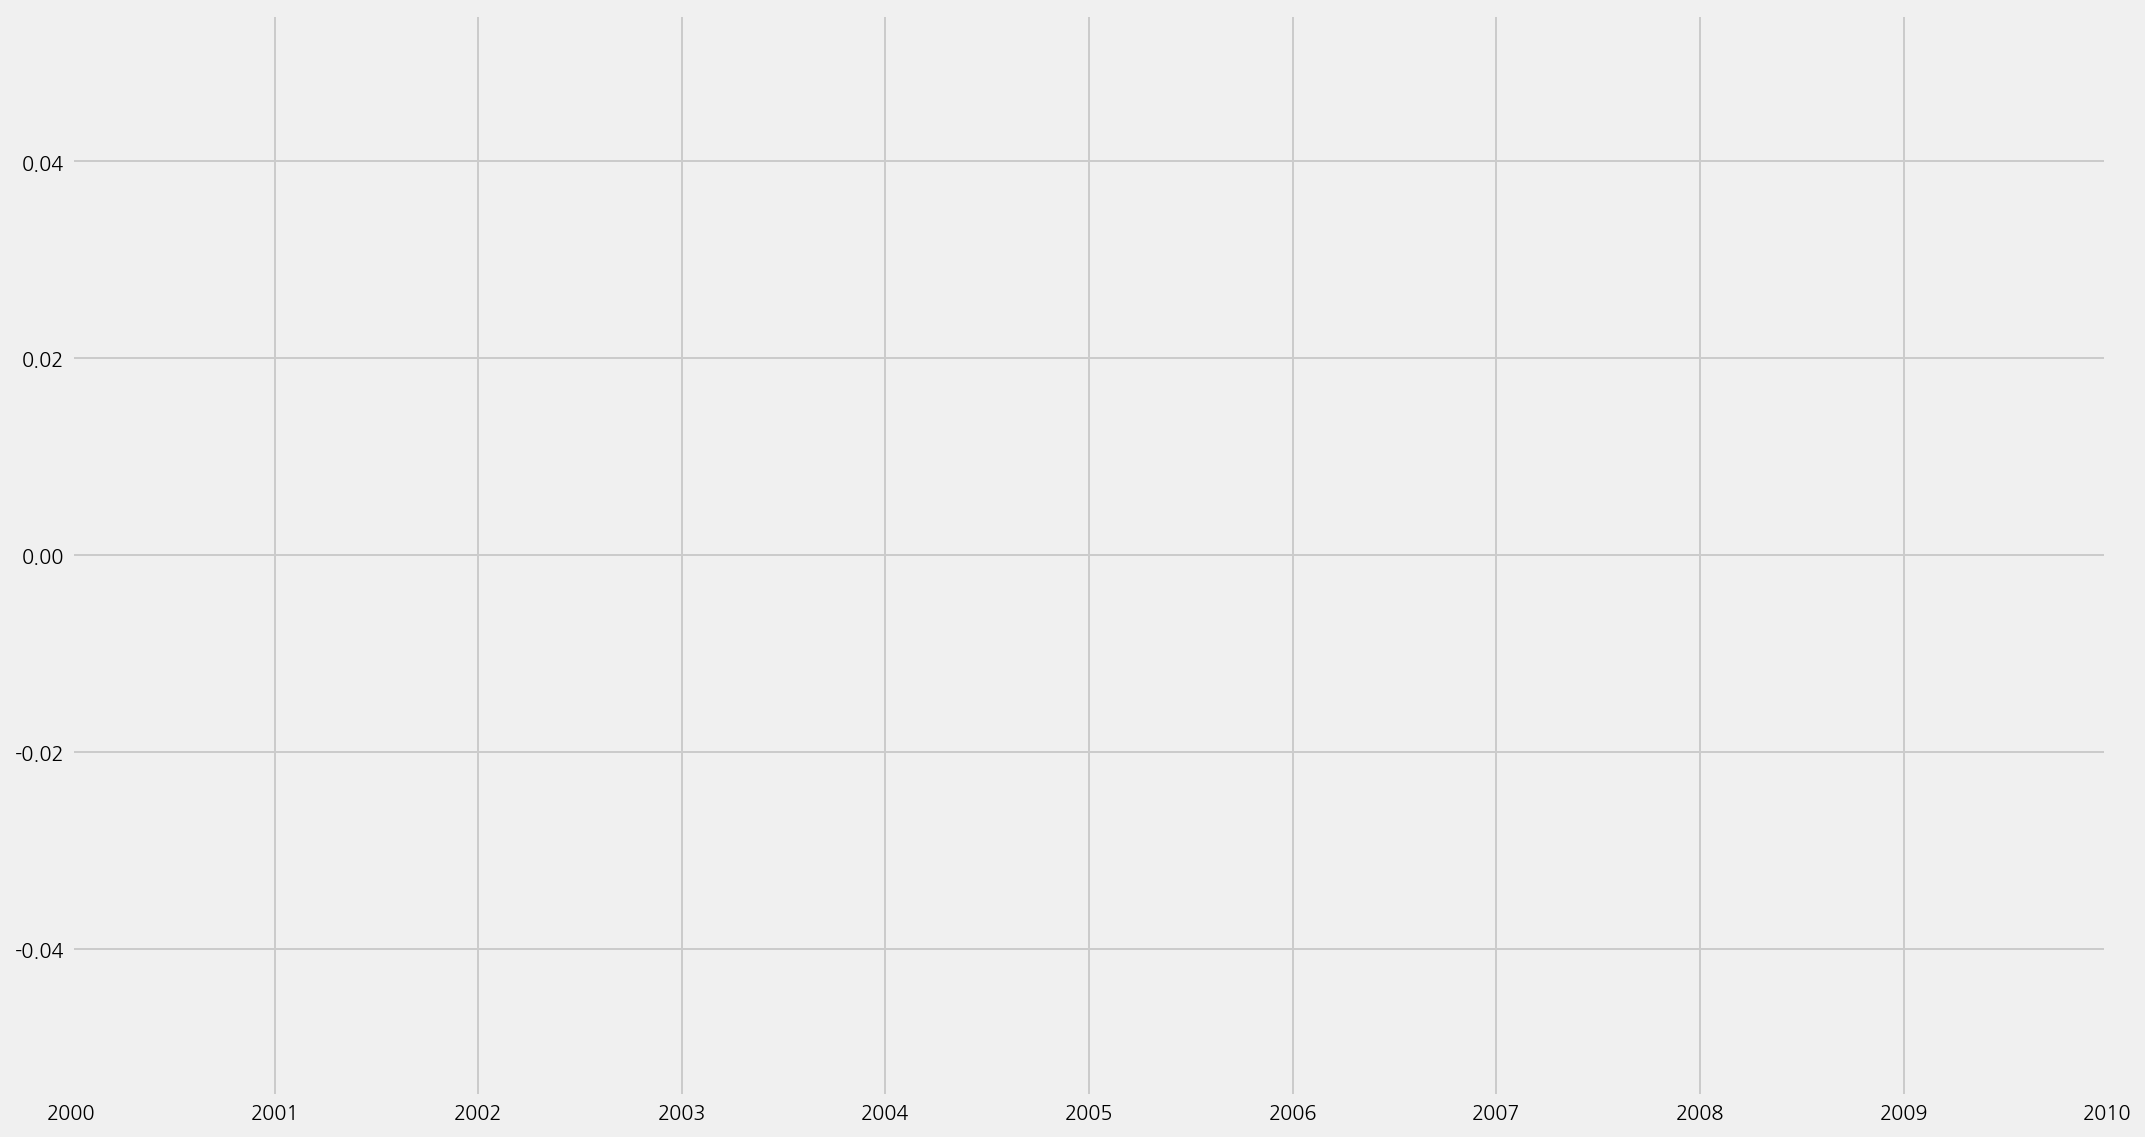

In [39]:
window = 16
fomc_data["polarity_ma"] = fomc_data.polarity_diffusion.rolling(window).mean()

cfg = eKonf.compose("visualize/plot=lineplot")
cfg.figure.figsize = (15, 8)
cfg.plot.x = "timestamp"
cfg.plots.append(cfg.plot.copy())
cfg.plots[0].y = "polarity_ma"
cfg.plots[0].linewidth = 2.5
cfg.plots[0].palette = "r"
cfg.plots[1].y = "polarity_diffusion"
cfg.plots[1].linewidth = 1.5
cfg.plots[1].palette = "g"
cfg.ax.title = f"Moving average of last {window} statements"
cfg.ax.legend.labels = [
    f"{window} statement MA",
    "Polarity score of individual statements",
]
cfg.ax.axvspans = spans
cfg.ax.annotations = annotations
eKonf.instantiate(cfg, data=fomc_data)

In [ ]:
from datetime import datetime

chair = fomc.chairpersons
chair = chair[chair.to_date.dt.year >= start_year]
annot_args = eKonf.compose("visualize/plot/ax/annotation")

spans = []
annotations = []
for row in chair.iterrows():
    row_num = row[0]
    start = row[1]["from_date"]
    if start.year < 2000:
        start = datetime(2000, 1, 1)
    end = row[1]["to_date"]
    annotation = row[1]["last_name"]
    color = "crimson" if row_num % 2 == 0 else "darkblue"
    alpha = 0.4 if row_num % 2 == 0 else 0.0
    span = {
        "xmin": eKonf.to_dateparm(start),
        "xmax": eKonf.to_dateparm(end),
        "alpha": alpha,
        "color": color,
    }

    x = start + (end - start) / 2
    y = -0.75
    annot = annot_args.copy()
    annot.text, annot.x, annot.y = annotation, eKonf.to_dateparm(x), y

    spans.append(span)
    annotations.append(annot)


In [ ]:
cfg = eKonf.compose("visualize/plot=lineplot")
cfg.plot.x = "timestamp"
ax2 = cfg.ax.copy()

cfg.figure.figsize = (15, 8)
cfg.plots.append(cfg.plot.copy())
cfg.plots[0].y = "polarity_ma"
cfg.plots[0].rcParams = dict(linewidth=2.5, color="red")
cfg.plots[1].y = "polarity_diffusion"
cfg.plots[1].rcParams = dict(linewidth=1.5, color="green")
cfg.ax.title = f"Moving average of last {window} statements"
cfg.ax.legend = dict(
    labels=[
        f"{window} statement MA",
        "Polarity score of individual statements",
    ],
    loc=2,
)
scatter_cfg = eKonf.compose("visualize/plot/scatterplot")
scatter_cfg.y = "DFEDTAR"
scatter_cfg.secondary_y = True
scatter_cfg.rcParams = dict(color="blue", alpha=0.8)
cfg.plots.append(scatter_cfg)

ax2.grid = False
ax2.secondary_y = True
ax2.ylim = "(-4, 10)"
ax2.legend = dict(
    labels=["Fed Rate"],
    loc=1,
)
cfg.axes.append(ax2)
cfg.ax.axvspans = spans
cfg.ax.annotations = annotations

eKonf.instantiate(cfg, data=fomc_data)
